In [46]:
#this is basically all of the code from 1-together, but with good stardards for measuring metrics

#start off with imports:
import torch
import matplotlib.pyplot as plt
from torch import nn
import pandas as pd
from sklearn.model_selection import train_test_split


#first lets make the dataset:

weights = 0.3
bias = 0.9

start = 0
end = 1
step = 0.02

#be sure to set the random state for reproducibility:
torch.manual_seed(seed=42)

X = torch.arange(start,end,step) #this shoudl create a size [50] tensor from 0 to 0.98
Y = X * weights + bias

#also, an intro to tensor slicing: 
# format is[start:stop:step], 
# start defaults to start or end of the array is step is + or - respectively
# stop defautls to the end or start of the array if step is + or - resp
#step is default 1

#thus [:5] will go from the start index(0) to before the end (4) and add each of those into a tensor, which will be returned

#for 2d tensors:
# [:2] will go from 0th index in the 0th dim to 1th index in teh 0th index and add those elements to a tensor
#(in this case, those elements are themselves tensors)
#in other words, it will return a tensor with the 0th and 1st row of the 2d tensor

#THE GENERAL FORMAT IS X[dim0,dim1,dim2, ...]
#where each dim is [::] for the start, stop step for that dimension

#exe: [:,:3,::-1] og tensor size [m,n,k]

# this will return a tensor of size [m,3,k] where the k columns are reversed

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,train_size=0.8,shuffle=False)


#now lets create the dataset using a pandas dataframe to see it
train_raw = {
    "Train_Data":X_train[:],
    "Train_Labels":Y_train[:]
    }
test_raw = {
    "Test_Data":X_test[:],
    "Test_Labels":Y_test[:]
}

df_train = pd.DataFrame(data=train_raw)
df_test = pd.DataFrame(data=test_raw)
df_train.head(),df_test.head()

(   Train_Data  Train_Labels
 0        0.00         0.900
 1        0.02         0.906
 2        0.04         0.912
 3        0.06         0.918
 4        0.08         0.924,
    Test_Data  Test_Labels
 0       0.80        1.140
 1       0.82        1.146
 2       0.84        1.152
 3       0.86        1.158
 4       0.88        1.164)

In [47]:
#lets inspect the data:
print(f"Train Data size: {X_train.shape},{X_train.device}")
print(f"Train Labels size: {Y_train.shape},{Y_train.device}")
print(f"Test Data size: {X_test.shape},{X_test.device}")
print(f"Test Labels size: {Y_test.shape},{Y_test.device}")

Train Data size: torch.Size([40]),cpu
Train Labels size: torch.Size([40]),cpu
Test Data size: torch.Size([10]),cpu
Test Labels size: torch.Size([10]),cpu


In [48]:
#now, lets make our code device agnostic

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device="cpu"


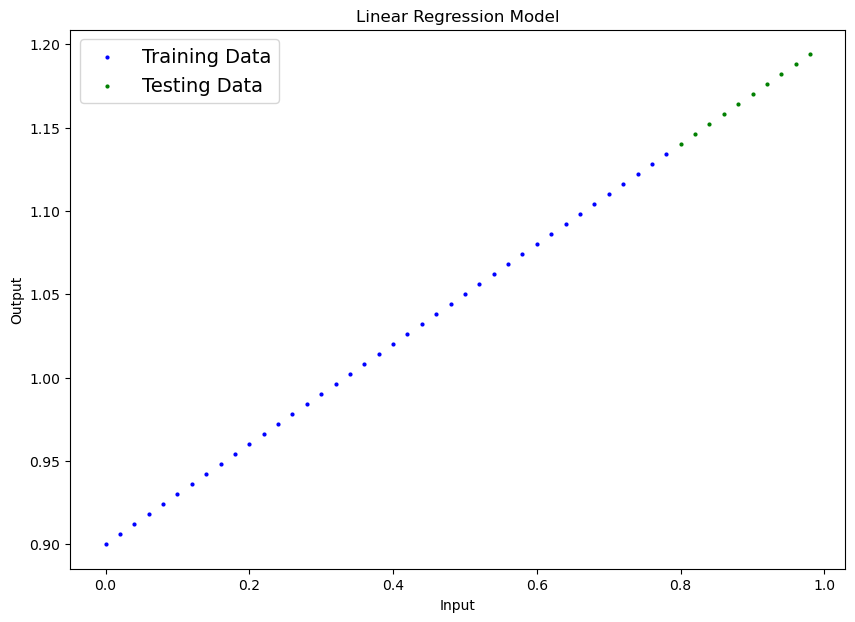

In [49]:
#now, lets plot our data: 

def plot_predictions(train_data,train_labels,test_data,test_labels,predictions = None):

    #first define the plot figure:
    plt.figure(figsize=(10,7))

    #now, lets get the scatterplot going for our data:
    plt.scatter(train_data,train_labels,c="b",s=4,label="Training Data")

    plt.scatter(test_data,test_labels,c="g",s=4,label="Testing Data")
    
    #now, for the conditional check for predictions:
    if predictions is not None:
        plt.scatter(test_data,predictions,c="r",s=4,label="Prediction")

    plt.title("Linear Regression Model")
    plt.xlabel("Input")
    plt.ylabel("Output")
    plt.legend(prop={"size":14})

    #normally, you can use the plt.subplot(1,2,1) to say that 1 row, 2 cols, index 1. But, here only one plot
    #still use the pl
    #each subplot gets it own title, xlabel, and ylabel
plot_predictions(train_data=X_train,train_labels=Y_train,test_data=X_test,test_labels=Y_test)


In [50]:
#now, lets try to import the plot predicitons model:
from pathlib import Path
import requests

#first, lets check if the user has the helper_functions.py file in their workspace:
# this creates a Path object that represents the path "helper_functions.py" relative to cwd
#can use p.exists() to see if file exists, or p.parent to find parent directory, p.touch() creates the file if it doesnt
#exist already

if Path("helper_functions.py").is_file():
    print("File already downloaded! Skipping Download...")
else:
    request = requests.get(url="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    #now request contains a request Response object with the data stored in memory, not on the disk (need to now write to disk)
    with open(file="helper_functions.py",mode="wb",newline="") as file:
        file.write(request.content)



File already downloaded! Skipping Download...


In [51]:
#we now have the helper_functions file downloaded! Now, we shoudl make the model:

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(data=torch.randn(size=(1,),dtype=torch.float),requires_grad=True)
        self.bias = nn.Parameter(data=torch.randn(size=(1,),dtype=torch.float),requires_grad=True)
    def forward(self,X: torch.Tensor) -> torch.Tensor:
        return X * self.weights.T + self.bias

model = LinearRegressionModel() #right now model is on CPU (which is needed for graphing and stuff)

print(f"Parameters: {list(model.parameters())}, \nState Dict: {model.state_dict()}")


Parameters: [Parameter containing:
tensor([0.3367], requires_grad=True), Parameter containing:
tensor([0.1288], requires_grad=True)], 
State Dict: OrderedDict({'weights': tensor([0.3367]), 'bias': tensor([0.1288])})


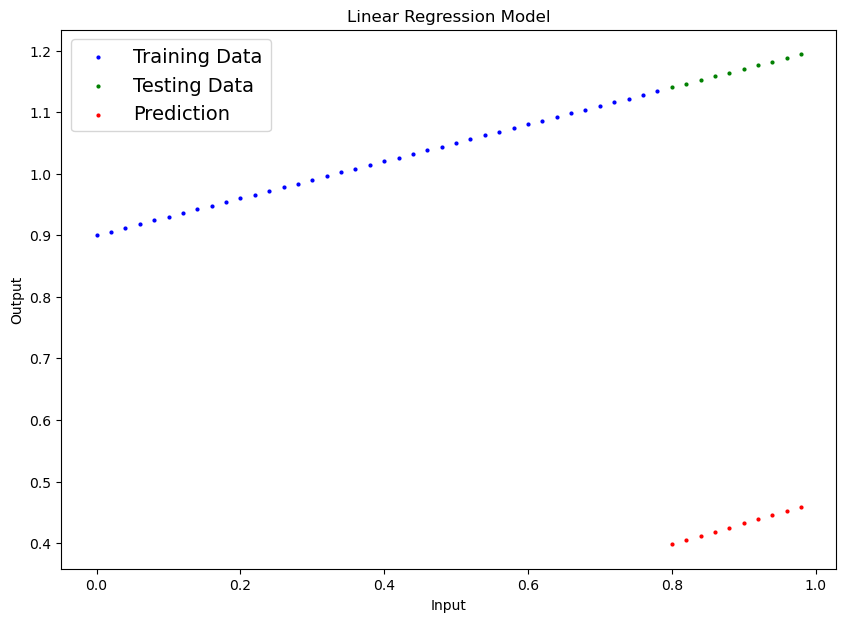

In [52]:
#now, lets make the model make a shot in the dark:

with torch.inference_mode():
    y_preds = model(X_test)

plot_predictions(train_data=X_train,train_labels=Y_train,test_data=X_test,test_labels=Y_test,predictions=y_preds)

In [53]:
#Now, that our model is done, we need to make the filesystem
from pathlib import Path 
from datetime import datetime

#define the things that vary
MODEL_NAME = "Unit1_Model"
EXPERIMENT_NAME = "exp1"

#also, learn now to get the current time
now = datetime.now()
TIMESTAMP = f"{now.month}-{now.year}-{str(now.year)[-2:]}-{now.strftime("%I-%M-%S%p")}"

#now, lets make the base directory:
BASE_DIR = Path(f"{MODEL_NAME}") 
EXPERIMENT_DIR = BASE_DIR / f"{EXPERIMENT_NAME}"

MODEL_DIR = EXPERIMENT_DIR / "models"
RESULTS_DIR = EXPERIMENT_DIR / "results"
GRAPHS_DIR = EXPERIMENT_DIR / "graphs"
LOSS_GRAPH_DIR = GRAPHS_DIR / "loss"
ACC_GRAPH_DIR = GRAPHS_DIR / "accuracy"

#now, recursively make these directories:
for directory in [BASE_DIR,EXPERIMENT_DIR,MODEL_DIR,RESULTS_DIR,GRAPHS_DIR,LOSS_GRAPH_DIR,ACC_GRAPH_DIR]:
    directory.mkdir(exist_ok=True,parents=True)

#FINALLY, make the path to the current experiment:

MODEL_PATH = MODEL_DIR / f"{MODEL_NAME}-{EXPERIMENT_NAME}-{TIMESTAMP}"
RESULTS_PATH = RESULTS_DIR / f"{MODEL_NAME}-{EXPERIMENT_NAME}-{TIMESTAMP}"
LOSS_GRAPH_PATH = LOSS_GRAPH_DIR / f"{MODEL_NAME}-{EXPERIMENT_NAME}-{TIMESTAMP}"
ACC_GRAPH_PATH = ACC_GRAPH_DIR / f"{MODEL_NAME}-{EXPERIMENT_NAME}-{TIMESTAMP}"





In [54]:
#now that our paths are in order, we can start the train-test loop:
loss_fn = torch.nn.L1Loss()
#L1LOSS will take two tensors y_preds and Y_train and calculate how wrong our guesses are.
#how does mean absolute error work: for each pair of predicted and actual value, find the absolute differene
# then sum all these differences, then divide by the total number of pts.

#basically, for the loss function theta, it will calculate the individual gradient for each value:
# so in our example it will find dL/dW which means when you slightly decrease weight, how much will it decrease the loss function

#then, it will nudge it by the gradent * the learning rate
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.001)

In [55]:
#NOW we can start the training loop. Be sure to create the csv writer to record the training and testing data,
import csv


#first, lets move our data to the GPU:
X_train,X_test,Y_train,Y_test = (tensor.to(device) for tensor in [X_train,X_test,Y_train,Y_test])
print(X_train.device,X_test.device,Y_train.device,Y_test.device)

#now, we should also ensure our model in on the gpu:
model.to(device) #the to(device) actually moves it and returns a reference to model (it is an object)

#now, lets set up the writer device using csv:
epochs = 10000

with open(file=RESULTS_PATH,mode="w",newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch","Training Loss", "Testing Loss"])
    #now, just proceed with the loop, but instead of appending to a list, writerow to the csv file
    for epoch in range(epochs):

        #start of the training loop
        #first, put the model in training mode:
        model.train()
        #now, we do a forward pass on the data to obtain the loss
        y_preds = model(X_train)

        #now, we can calculate the loss between the train preds and training actual
        loss = loss_fn(y_preds,Y_train)

        #now we zero the old gradients to prepare for a new epoch
        optimizer.zero_grad()

        #now, preform a backwards pass through the data and calculate the gradient with respect to every parameter
        loss.backward()

        #now, step the optimizer:
        optimizer.step()

        #NOW THE TESTING LOOP:
        model.eval()
        with torch.inference_mode():
            Y_test_preds = model(X_test)

            #find the test loss:
            test_loss = loss_fn(Y_test_preds,Y_test)

            #now, prepare to write the data:
            training_loss_write = loss.detach().cpu().numpy() #the loss is now a writable float
            testing_loss_write = test_loss.detach().cpu().numpy()

            #time to finally write the data:
            writer.writerow([epoch,training_loss_write,testing_loss_write])

            #now, the print statment:

            if epoch % 10 == 0:
                print(f"Epoch: {epoch} | Training Loss: {training_loss_write} | Testing Loss: {testing_loss_write}")



        


mps:0 mps:0 mps:0 mps:0
Epoch: 0 | Training Loss: 0.7568813562393188 | Testing Loss: 0.7371890544891357
Epoch: 10 | Training Loss: 0.7453603148460388 | Testing Loss: 0.7237180471420288
Epoch: 20 | Training Loss: 0.7338393330574036 | Testing Loss: 0.7102471590042114
Epoch: 30 | Training Loss: 0.7223183512687683 | Testing Loss: 0.6967762112617493
Epoch: 40 | Training Loss: 0.7107973694801331 | Testing Loss: 0.6833051443099976
Epoch: 50 | Training Loss: 0.699276328086853 | Testing Loss: 0.6698342561721802
Epoch: 60 | Training Loss: 0.6877554059028625 | Testing Loss: 0.656363308429718
Epoch: 70 | Training Loss: 0.6762343645095825 | Testing Loss: 0.6428923606872559
Epoch: 80 | Training Loss: 0.6647133827209473 | Testing Loss: 0.6294213533401489
Epoch: 90 | Training Loss: 0.653192400932312 | Testing Loss: 0.6159504055976868
Epoch: 100 | Training Loss: 0.6416714191436768 | Testing Loss: 0.6024794578552246
Epoch: 110 | Training Loss: 0.6301504373550415 | Testing Loss: 0.5890084505081177
Epoch:

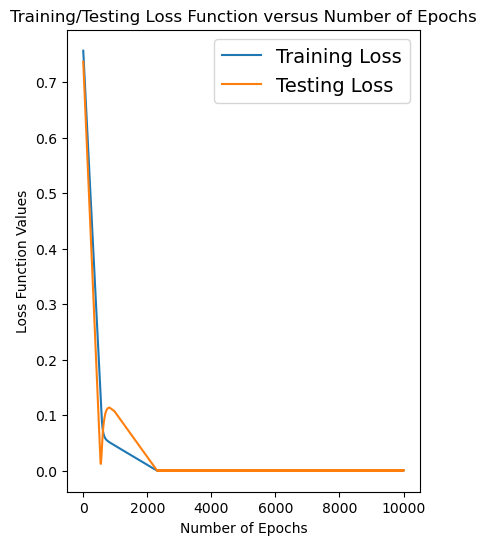

In [56]:
#now, our model has successfully trained! the current model is updated with teh new data and we have the csv
#files which we can use to graph!
import matplotlib.pyplot as plt
import pandas as pd 

#first, lets read the csv file into a pandas dataframe

df = pd.read_csv(RESULTS_PATH)

#now, using df["Epoch"], df["Training Loss"], and df["TESTING LOSS"], we can make the plot

#Now, for the plotting:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(df["Epoch"],df["Training Loss"],label="Training Loss")
plt.plot(df["Epoch"],df["Testing Loss"],label="Testing Loss")
plt.title("Training/Testing Loss Function versus Number of Epochs")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss Function Values")
plt.legend(prop={"size":14})
plt.savefig(LOSS_GRAPH_PATH) #saves it in the right place
plt.show() #this displays the plot
plt.close() #this closed the plot, meaning other commands after this are for a new plot






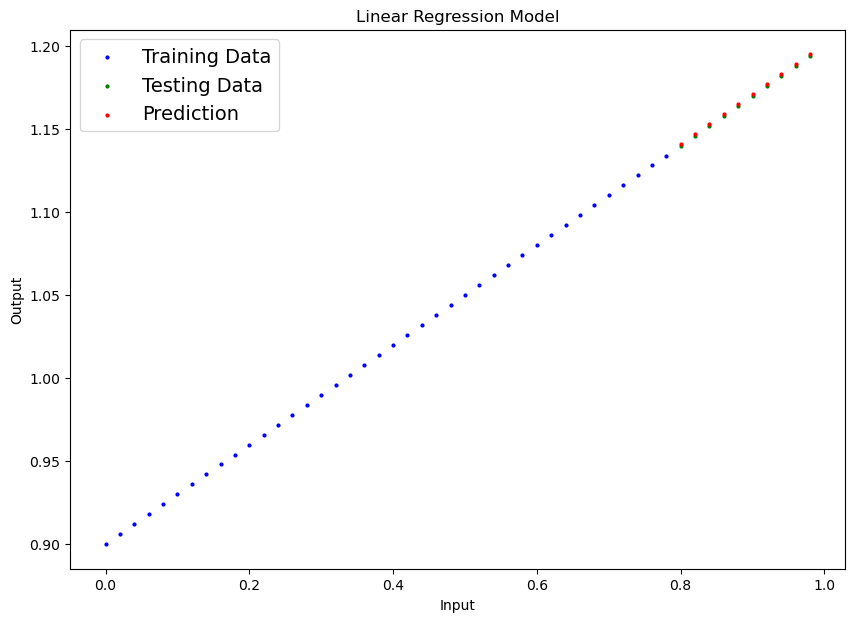

In [57]:
#now, we have successfully shown a graph of the loss function, which proves we did a good job
#lets run anouther inference on the model so see how it compares:

#be sure to move the data tensors back to the CPU so you can operate on them:

X_train,X_test,Y_train,Y_test = (tensor.to(device) for tensor in [X_train,X_test,Y_train,Y_test])

with torch.inference_mode():
    y_infer_preds = model(X_test)

X_train,X_test,Y_train,Y_test,y_infer_preds = (tensor.cpu() for tensor in [X_train,X_test,Y_train,Y_test,y_infer_preds])

plot_predictions(train_data=X_train,train_labels=Y_train,test_data=X_test,test_labels=Y_test,predictions=y_infer_preds)


In [58]:
#Now, lets save the model:

torch.save(obj=model.state_dict(),f=MODEL_PATH)

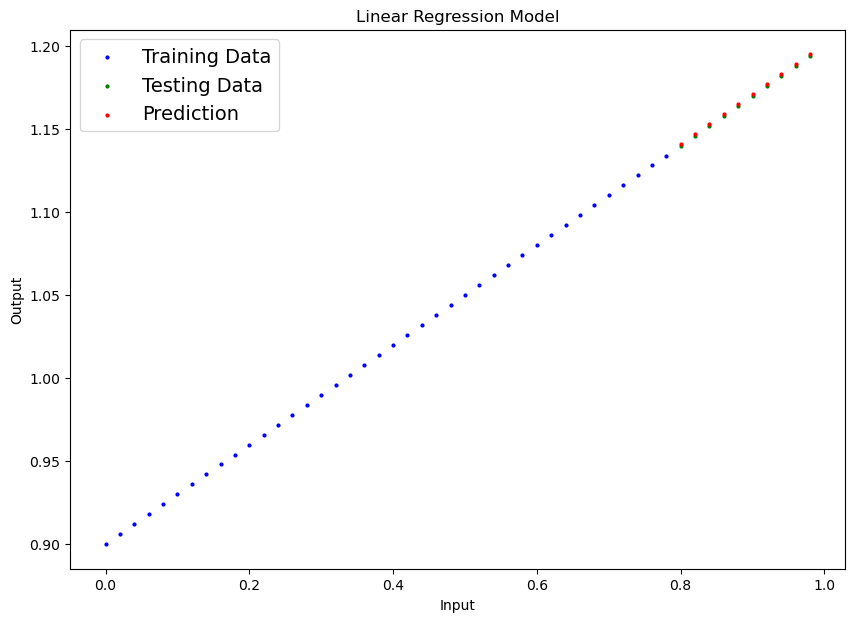

In [62]:
# Now, we should try to load the statedict into a new model

model_loaded = LinearRegressionModel().to(device)
model_loaded.load_state_dict(torch.load(f=MODEL_PATH,weights_only=True))


#now,lets try inference on it:

with torch.inference_mode():
    y_loaded_preds = model_loaded(X_test.to(device))

plot_predictions(train_data=X_train,train_labels=Y_train,test_data=X_test,test_labels=Y_test,predictions=y_loaded_preds.cpu())